In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *
import matplotlib.lines as mlines

label = 'relu'
nq = 4
n_step = 16
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func_list = list(func_out.keys())
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':2}

pnq = {'3':(3,8),
        '4':(4,16)}
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]

file_path = f"results/results_gvqs_{label}_{nq}.json"


In [2]:
df = pd.read_json(file_path)
df.head()

,Condition number,norm(yk),training_cost,exe_time,in_train_weights,RSS_q,RSS_h,seed
0,12730.232709,1.046311,"[0.45253383760000004, 0.46398277730000004, 0.3...",141785.884888,"[[0.1601059678, 2.8229354719, 1.8293098012, 0....",2.077205,1.768895,7498
1,12730.232709,1.046311,"[0.49670915660000003, 0.44478316430000003, 0.4...",108661.892636,"[[2.5048318007, 2.8973290117, 2.4623560801, 2....",0.077516,0.010579,5289
2,12730.232709,1.046311,"[0.4771129396, 0.4542505499, 0.4495125291, 0.4...",120942.523607,"[[0.4843168531, 2.3249346899, 0.8272285173, 1....",5.329755,4.669781,12
3,12730.232709,1.046311,"[0.43838630640000004, 0.3788885008, 0.47070683...",95534.714161,"[[0.7807175907, 1.4136394771, 1.2910086078, 0....",2.054769,1.748778,33
4,12730.232709,1.046311,"[0.4626666701, 0.46884439850000004, 0.42662472...",145357.089480,"[[3.038013838, 1.7191808138, 3.0557780395, 2.2...",2.039573,1.732888,4


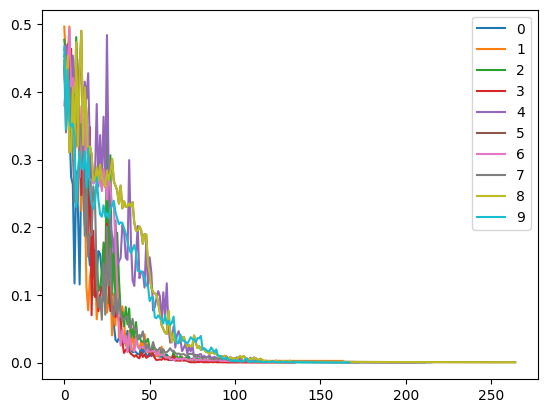

In [3]:
#Visualize training cost and obtain best performing epoch
argM = []
for i,item in enumerate(df["training_cost"].values):
    argM.append(np.argmin(item))
    plt.plot(item, label = i)
plt.legend()

beta_classic                 : [ 0.00000000e+00  6.25024975e-02 -8.75034965e-01  5.68772727e+00
 -2.27509091e+01  6.25650000e+01 -1.25130000e+02  1.87695000e+02
 -2.14430000e+02  1.87820000e+02 -1.24930000e+02  6.28200000e+01
 -2.24300000e+01  6.07000000e+00 -4.30000000e-01  5.70000000e-01]
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000002
0.9999999999999999
1.0


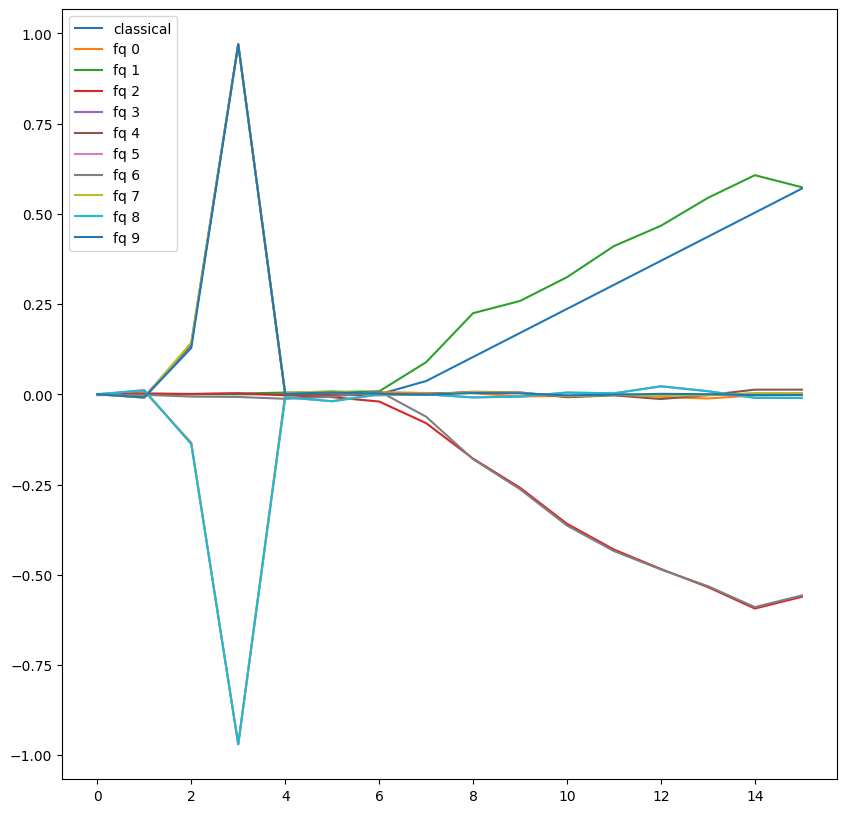

In [4]:
lower = 0. 
upper = 1. 
f_i = func_dict[label]
scaled=False
func = func_out[label]
x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]
matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
plt.figure(figsize=(10,10))

y_c=np.dot(matrix,c) #classic
plt.plot(range(len(y_c)),y_c, label="classical")
k_numb=np.linalg.cond(np.array(matrix))

vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 

for i,item in enumerate(df['in_train_weights']):
  weights = item[argM[i]]
  q = vqls_circuit.solution(weights).real
  y_q=np.dot(matrix,q) #hybrid
                        #Quantum

  y_fq=[]
  for el in matrix:
    y_fq.append(vqls_circuit.direct_prod2(weights,el))
  print(np.linalg.norm(q))
  #plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
  if i == 30:
    plt.plot(range(len(y_fq)),y_fq,label= f"fq {i}", linewidth = 10)
  else:
    plt.plot(range(len(y_fq)),y_fq,label= f"fq {i}")
plt.legend()

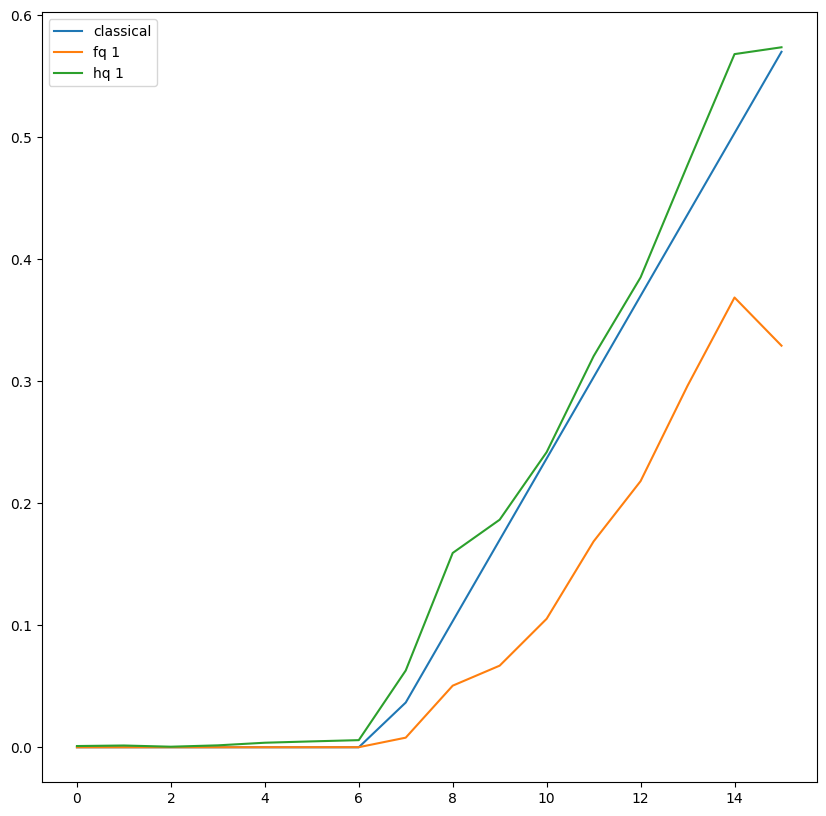

In [5]:
#Best performing model based on RSS
best = np.argmin(df['RSS_q'])


weights = df['in_train_weights'][best][argM[best]]
q = vqls_circuit.solution(weights).real
y_q=np.dot(matrix,q) #hybrid
                  #Quantum
plt.figure(figsize=(10,10))
plt.plot(range(len(y_c)),y_c, label="classical")

y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))

#plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
#plt.plot(range(len(y_fq)),np.abs(y_fq), label= f"fq abs {best}")
#plt.plot(range(len(y_fq)),np.abs(y_q), label= f"hq abs {best}")
plt.plot(range(len(y_fq)),np.power((y_fq),2), label= f"fq {best}")
plt.plot(range(len(y_fq)),(y_q), label= f"hq {best}")
plt.legend()
#plt.savefig(f'{file_path[:-5]}.png')
plt.show()

## Print approximation of best models for gvqsplines sigularly


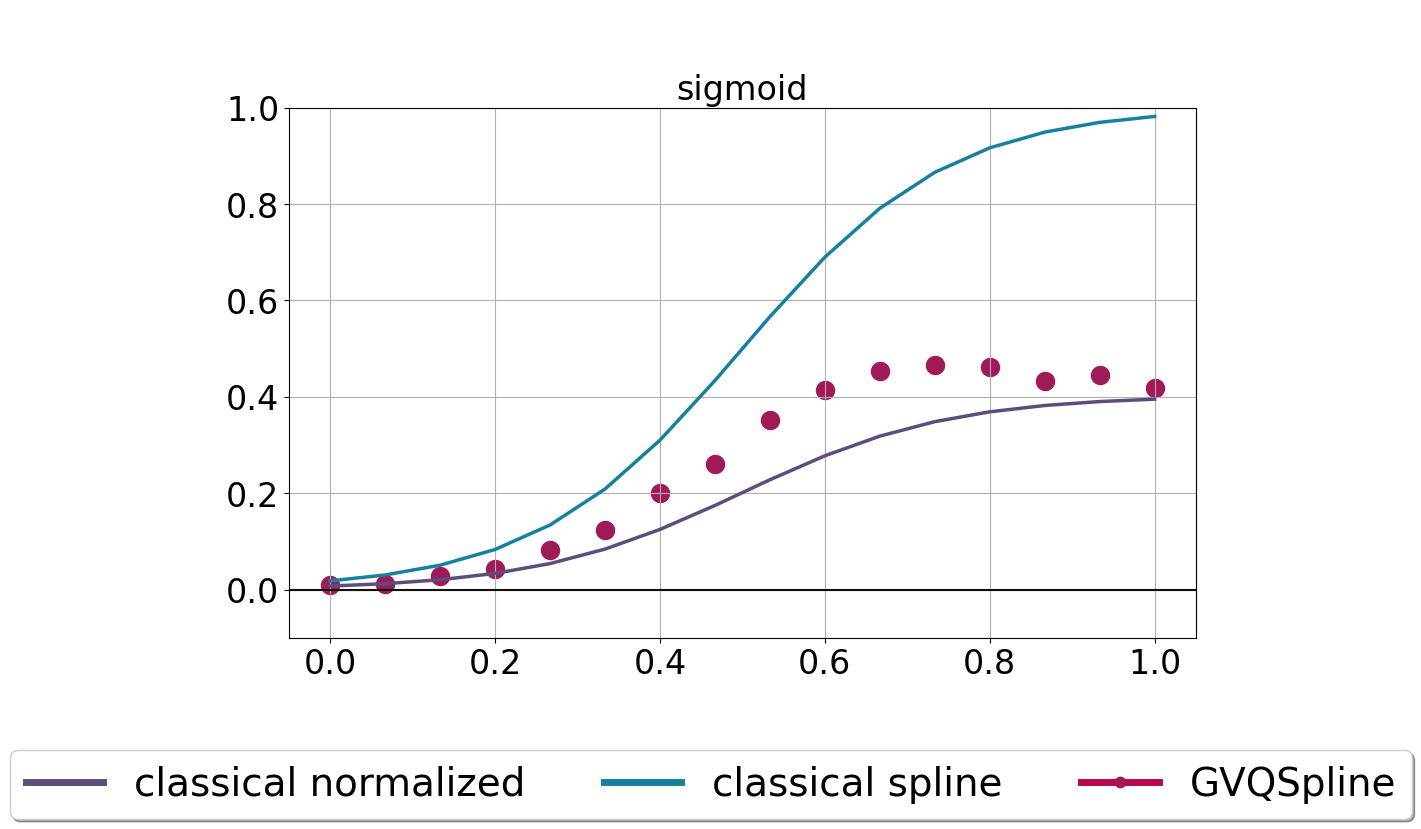

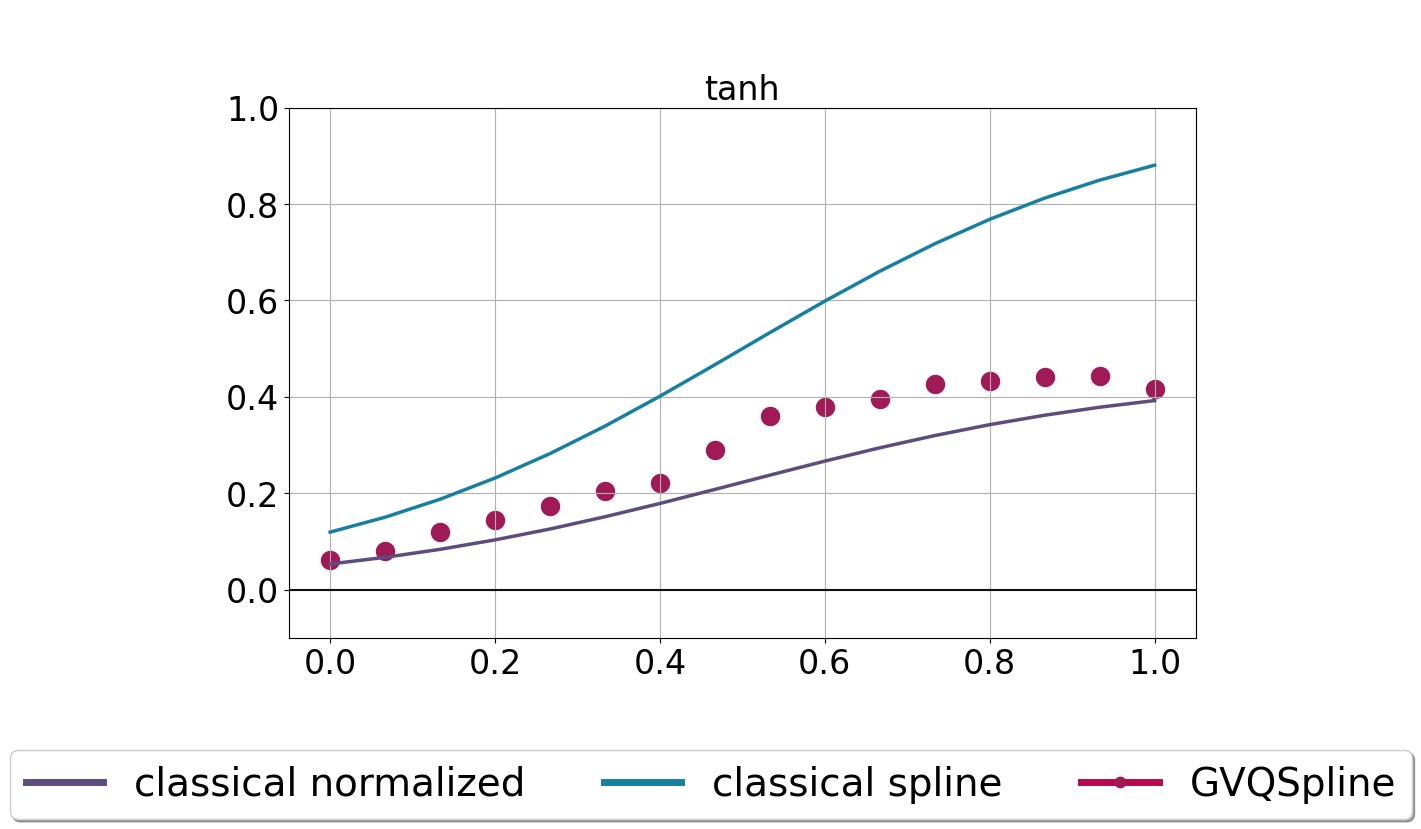

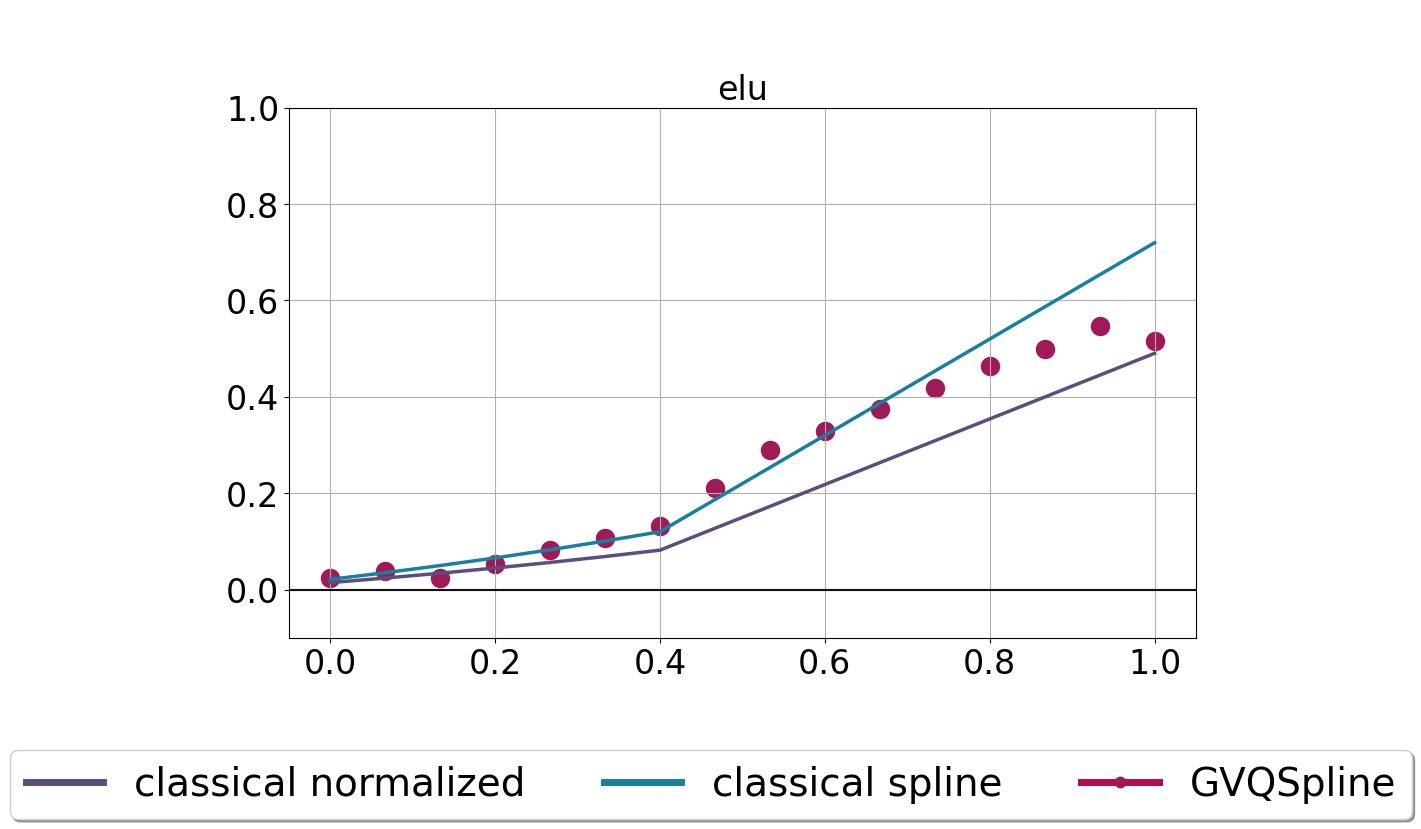

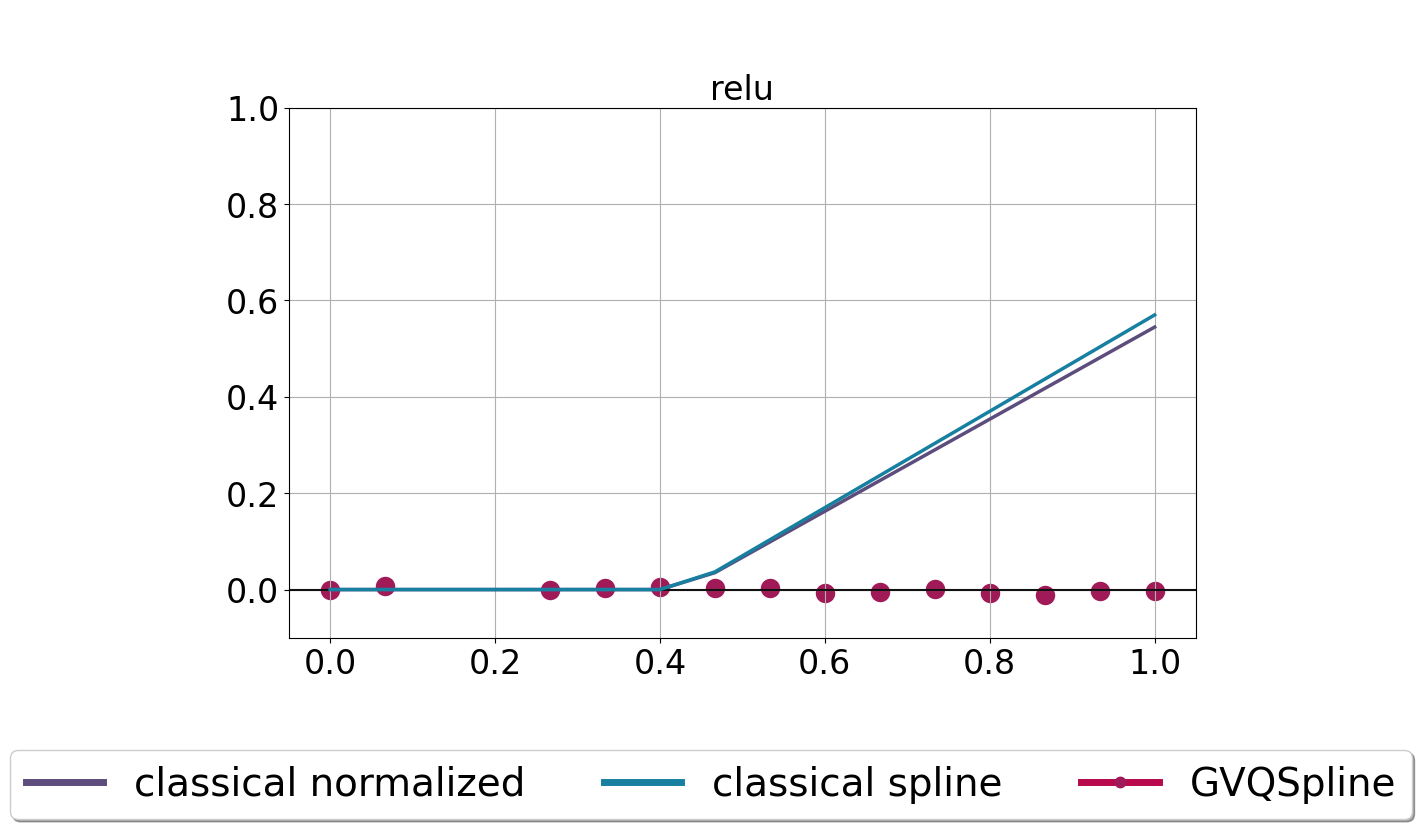

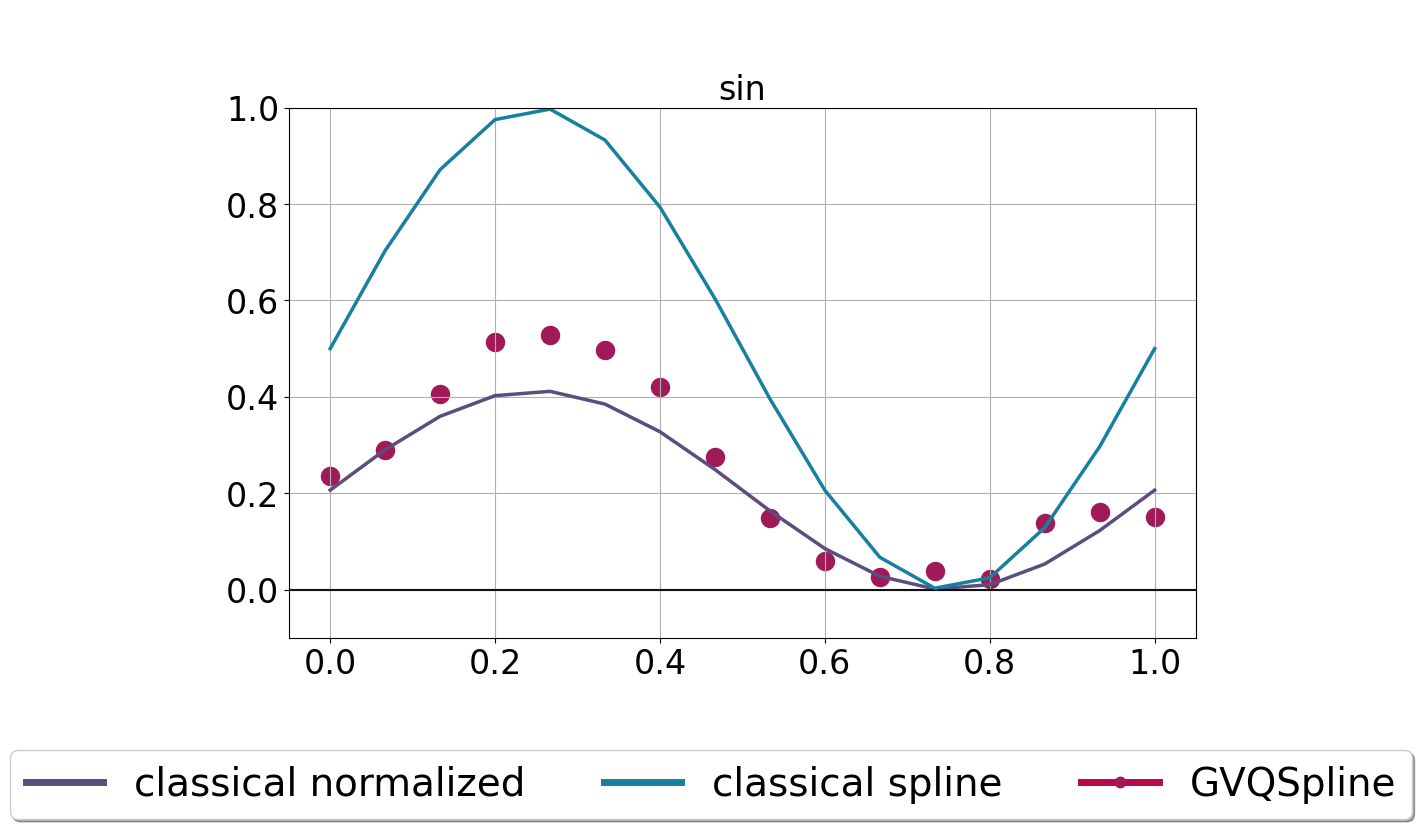

In [6]:
merge_figure=False
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func_list = list(func_out.keys())
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':2}

pnq = {# '3':(3,8),
        '4':(4,16)}
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]
tot = []
for flab, fun in func_out.items():
    for nq, knot in  pnq.values():
        file_path = f"results/results_gvqs_{flab}_{nq}.json"
        df = pd.read_json(file_path)
        best = np.argmin(df['RSS_q'])
        #if knot == 16 and flab == "sin":
        #    best = 0
        if knot == 16 and "relu" == flab:
            best = 0
        weights = df['in_train_weights'][best][-1]
        tot.append([flab, nq, knot, df.training_cost[best], df.exe_time[best], weights,df.RSS_h[best], df.RSS_q[best] ])
    
df = pd.DataFrame(tot, columns=columns)
df

j = 0
rss=[]
for flab, fun in func_out.items():
    fig = plt.figure(tight_layout = True, figsize=(10,7))
    fig.suptitle('Figure title')
    axE = fig.subfigures(1,1,)

    fig.suptitle(f'{flab}',fontsize=36)

    ax = [axE.subplots(nrows=1, ncols=1, sharey=True,)]

    ax[0].set_ylim(-0.1,1)
    
    j-=-1
    dl = df[df['function'] == flab]
    dl.reset_index(drop=True, inplace=True)
    #x = np.linspace(0, 1, 16).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#993333', alpha=0.2)
    #x = np.linspace(0, 1, 8).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#b300b3', alpha=0.2)
    for i, el in dl.iterrows():
        lower = 0.
        upper = 1.
        ax[i].tick_params(axis='both', which='major', labelsize=24)
        ax[i].grid(zorder = -3)

        f_i = func_dict[flab]
        scaled=False    
        label = flab
        n_step = el.knot
        x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
        xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
        y = [fun(value,f_i) for value in xx]

        #tck=splrep(x,y,k=1) #coeffs
        norm = np.linalg.norm(y)
        y = y / norm
        ax[i].plot(np.linspace(lower,upper,len(y)),y, label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=2.5)

        ax[i].axhline(0, color="#111111")
        
        matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)

        vqls_circuit = VQLS(matrix,v_norm,el['nq'],opt='COBYLA') 

        c = np.linalg.solve(matrix,vector)

        y_c=np.dot(matrix,c) #classic
        ax[i].plot(np.linspace(lower,upper,len(y_c)),vector, label="classical spline", color = '#1780a1',linewidth=2.5)

        y_fq=[]
        q = vqls_circuit.solution(el['weights']).real
        y_q=np.dot(matrix,q) #hybrid
                        #Quantum

        for a in matrix:
            y_fq.append(vqls_circuit.direct_prod2(el['weights'],a))
        rssss = math.sqrt(np.square(np.subtract(y_c,np.abs(y_fq))).mean())
        rssss2 = math.sqrt(np.square(np.subtract(y,np.abs(y_fq))).mean())
        rss.append(rssss)
        colorl = '#b7094c'
        colors = '#a01a58'
        #ax[i].plot(np.linspace(lower,upper,len(y_fq)),np.abs(y_fq),label= f"full quantum {n_step}", color=colorl, zorder= -1, lw=5)
        ax[i].scatter(np.linspace(lower,upper,len(y_fq)),(y_fq), color=colors, linewidths=8)
        #plt.scatter(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #plt.plot(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #ax[i].text(0.35,0.87, f"rmse scaled = {rssss2:.4f}\n" \
        #    f"rmse classical = {rssss:.4f}\n", fontsize=14)
        ax[i].set_title(f'{flab}',fontsize=24)
        #ax[i].set_title(f'{n_step} steps',fontsize=24)


        #ax[i].legend(fontsize=18)
    handles = [mlines.Line2D([], [], color='#5c4d7d', linewidth=5, label='classical normalized')]
    handles.append(mlines.Line2D([], [], color='#1780a1', linewidth=5, label='classical spline'))
    handles.append(mlines.Line2D([], [], color=colorl, marker='.',linewidth=5,
                        markersize=15, label='GVQSpline', markerfacecolor=colors, markeredgecolor=colors))

    lgd = axE.legend(handles = handles, loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5, fontsize = 28)
    #fig.savefig(f'plots/n_gvqs_{flab}_plot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

    plt.show()






## Print approximation of best models for gvqspline


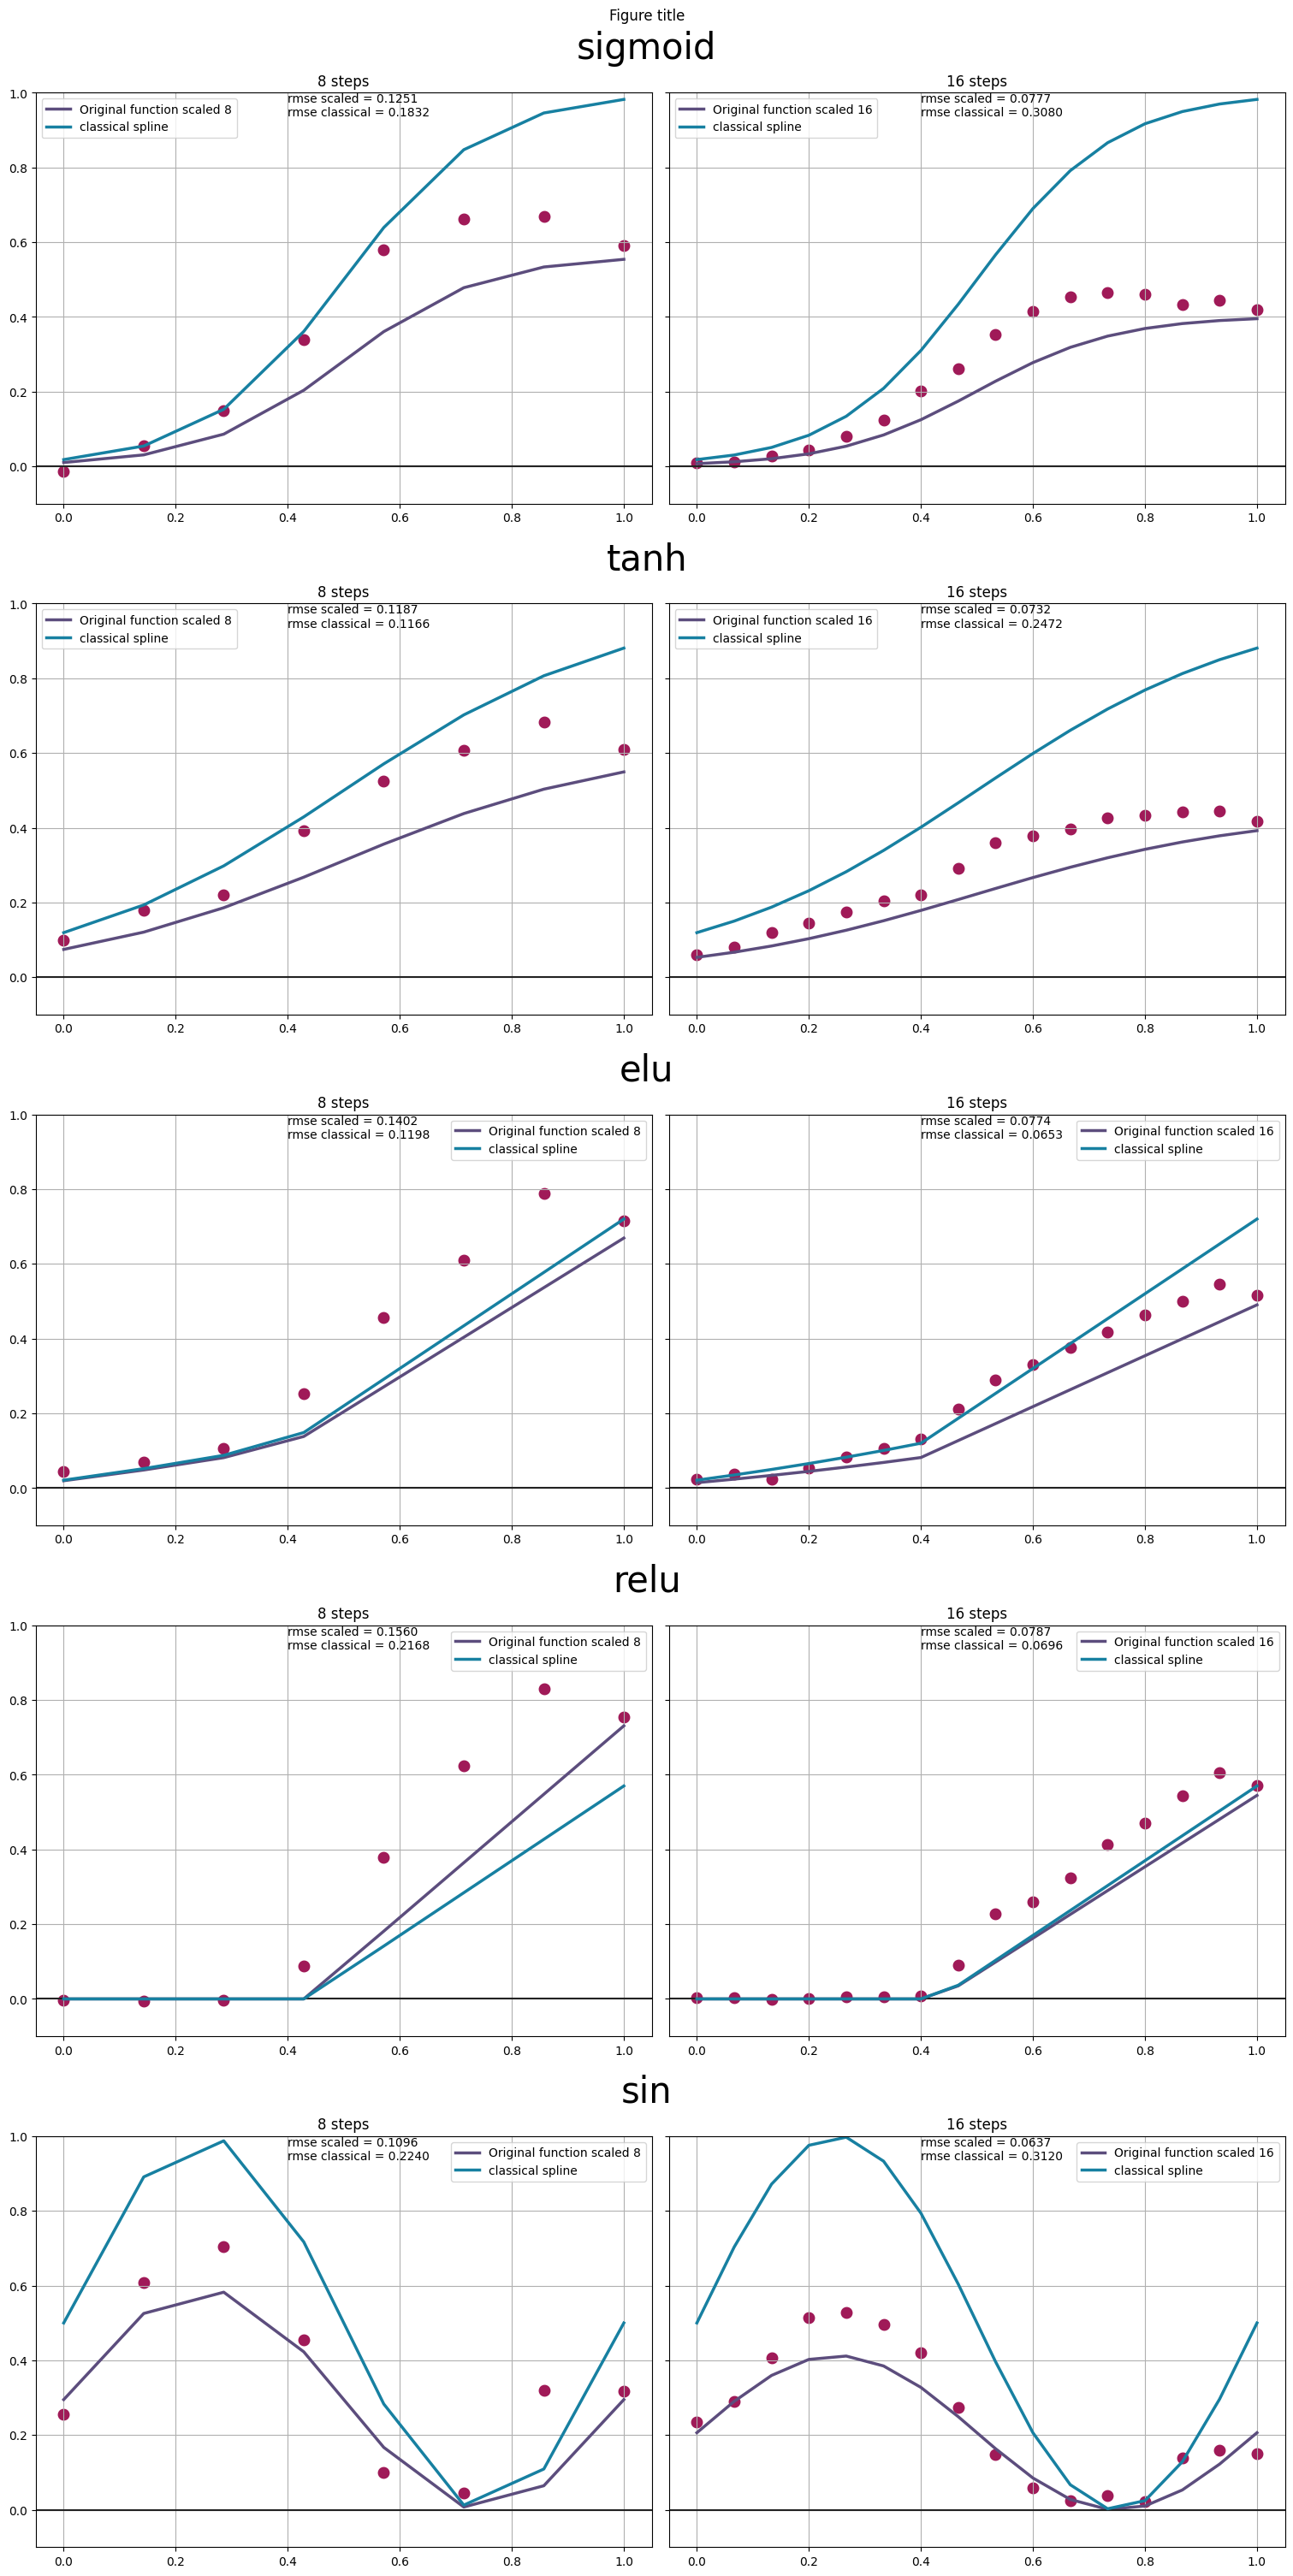

In [11]:
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func_list = list(func_out.keys())
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':2}

pnq = {'3':(3,8),
        '4':(4,16)}
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]
tot = []
for flab, fun in func_out.items():
    for nq, knot in  pnq.values():
        file_path = f"results/results_gvqs_{flab}_{nq}.json"
        df = pd.read_json(file_path)
        best = np.argmin(df['RSS_q'])
        #if knot == 16 and flab == "sin":
        #    best = 0
        #if knot == 16 and "relu" == flab:
        #    best = 0
        weights = df['in_train_weights'][best][-1]
        tot.append([flab, nq, knot, df.training_cost[best], df.exe_time[best], weights,df.RSS_h[best], df.RSS_q[best] ])
    
df = pd.DataFrame(tot, columns=columns)
df

fig = plt.figure(constrained_layout=True, figsize=(15,30))
fig.suptitle('Figure title')
axE = fig.subfigures(5,1,  )
j = 0
rss=[]
for flab, fun in func_out.items():
    axE[j].suptitle(f'{flab}',fontsize=30)

    ax = axE[j].subplots(nrows=1, ncols=2, sharey=True,)

    ax[0].set_ylim(-0.1,1)

    j-=-1
    dl = df[df['function'] == flab]
    dl.reset_index(drop=True, inplace=True)
    #x = np.linspace(0, 1, 16).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#993333', alpha=0.2)
    #x = np.linspace(0, 1, 8).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#b300b3', alpha=0.2)
    for i, el in dl.iterrows():
        lower = 0.
        upper = 1.

        f_i = func_dict[flab]
        scaled=False    
        label = flab
        n_step = el.knot
        x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
        xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
        y = [fun(value,f_i) for value in xx]

        #tck=splrep(x,y,k=1) #coeffs
        norm = np.linalg.norm(y)
        y = y / norm
        ax[i].plot(np.linspace(lower,upper,len(y)),y, label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=2.5)

        ax[i].axhline(0, color="#222222")
        
        matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)

        vqls_circuit = VQLS(matrix,v_norm,el['nq'],opt='COBYLA') 

        c = np.linalg.solve(matrix,vector)

        y_c=np.dot(matrix,c) #classic
        ax[i].plot(np.linspace(lower,upper,len(y_c)),vector, label="classical spline", color = '#1780a1',linewidth=2.5)

        y_fq=[]
        q = vqls_circuit.solution(el['weights']).real
        y_q=np.dot(matrix,q) #hybrid
                        #Quantum

        for a in matrix:
            y_fq.append(vqls_circuit.direct_prod2(el['weights'],a))
        rssss = math.sqrt(np.square(np.subtract(y_c,y_fq)).mean())
        rssss2 = math.sqrt(np.square(np.subtract(y,y_fq)).mean())
        rss.append(rssss)
        colorl = '#b7094c'
        colors = '#a01a58'
        #ax[i].plot(np.linspace(lower,upper,len(y_fq)),np.abs(y_fq),label= f"full quantum {n_step}", color=colorl)
        ax[i].scatter(np.linspace(lower,upper,len(y_fq)),y_fq, color=colors, linewidths=4)
        #plt.scatter(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #plt.plot(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        ax[i].text(0.4,0.9, f"rmse scaled = {rssss2:.4f}\n" \
            f"rmse classical = {rssss:.4f}\n")
        ax[i].set_title(f'{n_step} steps')
        ax[i].legend()
        ax[i].grid()
#plt.savefig(f'full_plots.png')
plt.show()



#  Print VQSpline

In [12]:
func_out = {'sigmoid': sigmoid_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}#'tanh': tanh_t,}
func_list = list(func_out.keys())
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':2}

pnq = {# '3':(3,8),
        '4':(4,16)}
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]
tot = []
for flab, fun in func_out.items():
    for nq, knot in  pnq.values():
        file_path = f"results/results_gvqs_{flab}_{nq}.json"
        df = pd.read_json(file_path)
        best = np.argmin(df['RSS_q'])
        #if knot == 16 and flab == "sin":
        #    best = 0
        #if knot == 16 and "relu" == flab:
        #    best = 0
        weights = df['in_train_weights'][best][-1]
        tot.append([flab, nq, knot, df.training_cost[best], df.exe_time[best], weights,df.RSS_h[best], df.RSS_q[best] ])
    
df = pd.DataFrame(tot, columns=columns)
df


,function,nq,knot,training cost,time(s),weights,RSS_h,RSS_q
0,sigmoid,4,16,"[0.436504891, 0.3373845206, 0.2353528699, 0.21...",139828.309502,"[1.5756719111000002, 3.1864332824, 3.007082071...",2.059185,1.518124
1,elu,4,16,"[0.4901639498, 0.4618650857, 0.448412788300000...",90587.401667,"[3.1883845824, 1.9524916928, 0.467479085200000...",0.143556,0.068217
2,relu,4,16,"[0.49670915660000003, 0.44478316430000003, 0.4...",108661.892636,"[3.14734508, 3.3656694503, 2.2719104715, 3.280...",0.010579,0.077516
3,sin,4,16,"[0.17927684230000002, 0.36585478390000004, 0.2...",164930.070595,"[0.5486421942, 2.5420301889, 3.0675882172, 2.9...",2.153892,1.557386


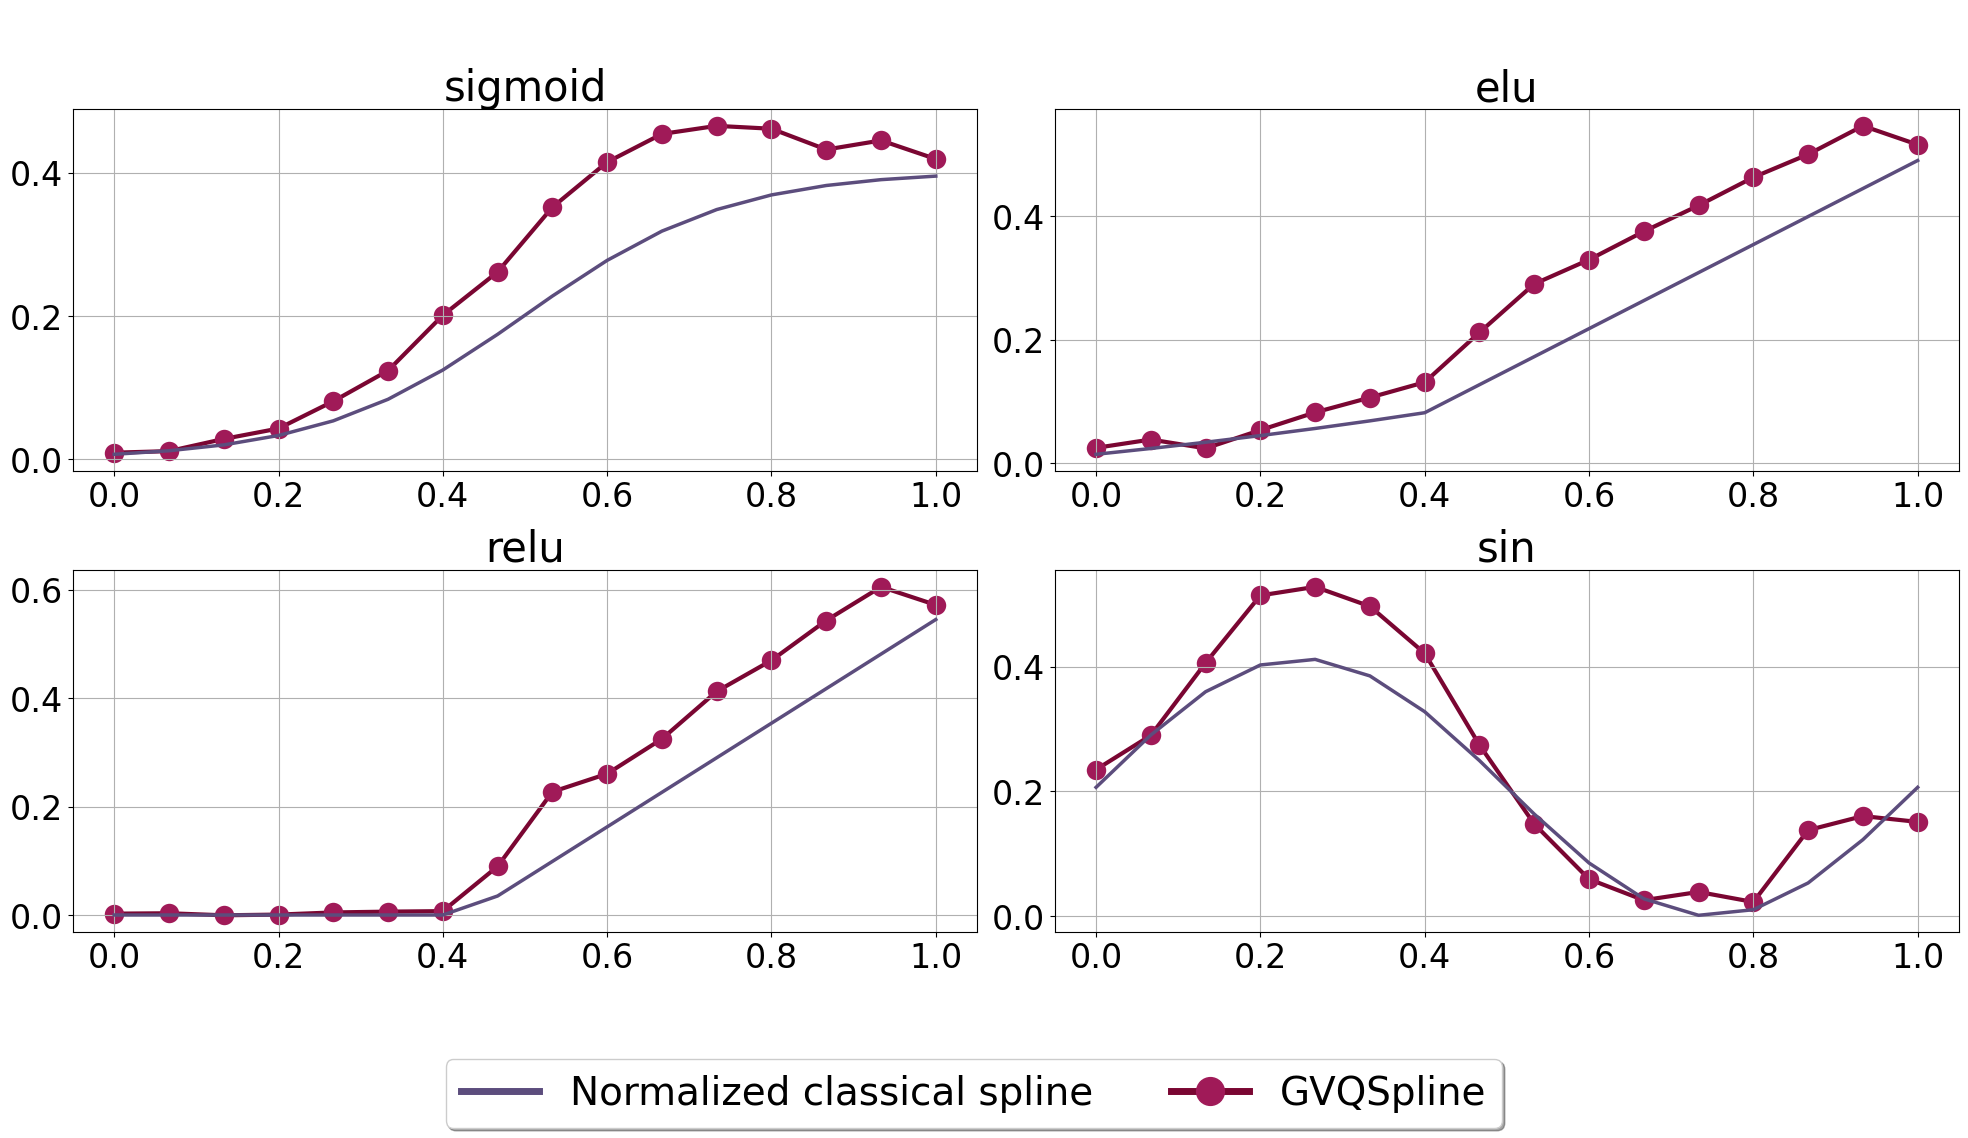

In [18]:

j = 0
k = 0
rss=[]
fig = plt.figure(tight_layout = True, figsize=(20,10))

fig.suptitle('Figure title')
axE = fig.subfigures(1,1,)

fig.suptitle(f'{flab}',fontsize=36)

ax = axE.subplots(nrows=2, ncols=2, sharey=False,)
fig.subplots_adjust(hspace=1)

for flab, fun in func_out.items():

    #ax[k][j].set_ylim(-0.1,1)
    

    dl = df[df['function'] == flab]
    dl.reset_index(drop=True, inplace=True)
    #x = np.linspace(0, 1, 16).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#993333', alpha=0.2)
    #x = np.linspace(0, 1, 8).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#b300b3', alpha=0.2)
    for i, el in dl.iterrows():
        lower = 0.
        upper = 1.
        ax[k][j].tick_params(axis='both', which='major', labelsize=24)
        ax[k][j].grid(zorder = -3)

        f_i = func_dict[flab]
        scaled=False    
        label = flab
        n_step = el.knot
        x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
        xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
        y = [fun(value,f_i) for value in xx]

        #tck=splrep(x,y,k=1) #coeffs
        norm = np.linalg.norm(y)
        y = y / norm
        ax[k][j].plot(np.linspace(lower,upper,len(y)),y,  label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=2.5)

        #ax[k][j].axhline(0, color="#111111")
        
        matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)

        vqls_circuit = VQLS(matrix,v_norm,el['nq'],opt='COBYLA') 

        c = np.linalg.solve(matrix,vector)

        y_c=np.dot(matrix,c) #classic
        #ax[k][j].plot(np.linspace(lower,upper,len(y_c)),vector, label="classical spline", color = '#1780a1',linewidth=2.5)

        y_fq=[]
        q = vqls_circuit.solution(el['weights']).real
        y_q=np.dot(matrix,q) #hybrid
                        #Quantum

        for a in matrix:
            y_fq.append(vqls_circuit.direct_prod2(el['weights'],a))
        rssss = math.sqrt(np.square(np.subtract(y_c,np.abs(y_fq))).mean())
        rssss2 = math.sqrt(np.square(np.subtract(y,np.abs(y_fq))).mean())
        rss.append(rssss)
        colorl = '#7a0632'
        colors = '#a01a58'
        ax[k][j].plot(np.linspace(lower,upper,len(y_fq)),y_fq, color=colorl, zorder= -1, lw=3)
        ax[k][j].scatter(np.linspace(lower,upper,len(y_fq)),(y_fq), color=colors, linewidths=8)
        #plt.scatter(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #plt.plot(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #ax[i].text(0.35,0.87, f"rmse scaled = {rssss2:.4f}\n" \
        #    f"rmse classical = {rssss:.4f}\n", fontsize=14)
        ax[k][j].set_title(f'{flab}',fontsize=30)
        #ax[i].set_title(f'{n_step} steps',fontsize=24)


        #ax[i].legend(fontsize=18)
    j-=-1
    if(j%2==0):
        j = 0
        k -=-1

handles = [mlines.Line2D([], [], color='#5c4d7d', linewidth=5, label='Normalized classical spline')]
#handles.append(mlines.Line2D([], [], color='#1780a1', linewidth=5, label='classical spline'))
handles.append(mlines.Line2D([], [], color=colorl, marker='.',linewidth=5,
                    markersize=40, label='GVQSpline', markerfacecolor=colors, markeredgecolor=colors))

lgd = axE.legend(handles = handles, loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5, fontsize = 28)
fig.savefig(f'plots/n_gvqsplot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()




